# Task 3: Helper notebook for loading the data and saving the predictions

In [1]:
import pickle
import gzip
import numpy as np
import os

In [270]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from skimage.transform import resize

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import adam_v2
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, BatchNormalization
from keras import backend as K

import cv2


### Helper functions

In [326]:
def build_model_normalization(input_layer, start_neurons):
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = BatchNormalization()(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = BatchNormalization()(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = BatchNormalization()(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = BatchNormalization()(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

In [327]:
def build_model(input_layer, start_neurons):
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

In [4]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object

In [5]:
def save_zipped_pickle(obj, filename):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, 2)

In [6]:
def evaluate(predictions, targets):
    ious = []
    for p, t in zip(predictions, targets):
        assert p['name'] == t['name']
        prediction = np.array(p['prediction'], dtype=bool)
        target = np.array(t['label'], dtype=bool)

        assert target.shape == prediction.shape
        overlap = prediction*target
        union = prediction + target

        ious.append(overlap.sum()/float(union.sum()))
    
    print("Median IOU: ", np.median(ious))

In [314]:
def preprocess_train(data, img_size_target):
    X_fin, y_fin = [], []
    video = data['video']
    frames = data['frames']
    label = data['label']
    h, w = video.shape[0], video.shape[1]
    X = video[:,:,frames]
    y = label[:,:,frames] * 1
    X = cv2.resize(X, (img_size_target, img_size_target), interpolation = cv2.INTER_NEAREST)
    y = cv2.resize(y, (img_size_target, img_size_target), interpolation = cv2.INTER_NEAREST)
    y = (y > 0) * 1.0
    for i in range(len(frames)):
        X_fin.append(X[:,:,i])
        y_fin.append(y[:,:,i])
    return X_fin, y_fin

In [379]:
def preprocess_test(data, img_size_target):
    X_fin = []
    video = data['video']
    for i in range(video.shape[2]):
        frame = cv2.resize(video[:,:,i], (img_size_target, img_size_target), interpolation = cv2.INTER_NEAREST)
        X_fin.append(frame)
    return X_fin

In [295]:
def jaccard_similarity(y_train, y_test):
    y_train_f = K.flatten(y_train)
    y_test_f = K.flatten(y_test)
    intersection = K.sum(y_train_f * y_test_f)
    union = K.sum(y_train_f) + K.sum(y_test_f) - intersection
    return intersection / union

In [296]:
def jaccard_loss(y_train, y_test):
    return - jaccard_similarity(y_train, y_test)

### Load data and Initiate variables

In [96]:
# load data
train_data = load_zipped_pickle("train.pkl")
test_data = load_zipped_pickle("test.pkl")
samples = load_zipped_pickle("sample.pkl")

In [97]:
img_size_target = 112
train = train_data
test = test_data

### Detection

In [432]:
X, y = [], []
for data in train:
    X_new, y_new = preprocess_train(data, img_size_target)
    X += X_new
    y += y_new
X = np.array(X)
y = np.array(y)

In [433]:
X.shape

(195, 112, 112)

In [434]:
n = 3 * 10
X_train = X[:-n,:,:]
X_val = X[-n:,:,:]
y_train = y[:-n,:,:]
y_val = y[-n:,:,:]

In [510]:
input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16)

In [511]:
model = Model(input_layer, output_layer)

In [512]:
model.compile(loss=jaccard_loss, optimizer="adam", metrics=[jaccard_similarity, 'accuracy'])

In [521]:
epochs = 200
batch_size = 32

early_stopping = EarlyStopping(patience=25, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)


history = model.fit(X_train, y_train,
                    validation_data=[X_val, y_val], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/200
6/6 [==============================] - ETA: 0s - loss: -0.6509 - jaccard_similarity: 0.6518 - accuracy: 0.9960
Epoch 00001: val_loss improved from inf to -0.41912, saving model to .\keras.model
INFO:tensorflow:Assets written to: .\keras.model\assets
6/6 [==============================] - 17s 3s/step - loss: -0.6509 - jaccard_similarity: 0.6518 - accuracy: 0.9960 - val_loss: -0.4191 - val_jaccard_similarity: 0.4191 - val_accuracy: 0.9935
Epoch 2/200
6/6 [==============================] - ETA: 0s - loss: -0.6500 - jaccard_similarity: 0.6449 - accuracy: 0.9961
Epoch 00002: val_loss did not improve from -0.41912
6/6 [==============================] - 14s 2s/step - loss: -0.6500 - jaccard_similarity: 0.6449 - accuracy: 0.9961 - val_loss: -0.4173 - val_jaccard_similarity: 0.4173 - val_accuracy: 0.9933
Epoch 3/200
6/6 [==============================] - ETA: 0s - loss: -0.6534 - jaccard_similarity: 0.6482 - accuracy: 0.9960
Epoch 00003: val_loss improved from -0.41912 to -0.42473, 

6/6 [==============================] - ETA: 0s - loss: -0.6662 - jaccard_similarity: 0.6650 - accuracy: 0.9963
Epoch 00022: val_loss did not improve from -0.45197
6/6 [==============================] - 13s 2s/step - loss: -0.6662 - jaccard_similarity: 0.6650 - accuracy: 0.9963 - val_loss: -0.4424 - val_jaccard_similarity: 0.4424 - val_accuracy: 0.9938
Epoch 23/200
6/6 [==============================] - ETA: 0s - loss: -0.6601 - jaccard_similarity: 0.6624 - accuracy: 0.9962
Epoch 00023: val_loss did not improve from -0.45197
6/6 [==============================] - 13s 2s/step - loss: -0.6601 - jaccard_similarity: 0.6624 - accuracy: 0.9962 - val_loss: -0.4277 - val_jaccard_similarity: 0.4277 - val_accuracy: 0.9935
Epoch 24/200
6/6 [==============================] - ETA: 0s - loss: -0.6647 - jaccard_similarity: 0.6680 - accuracy: 0.9962
Epoch 00024: val_loss did not improve from -0.45197
6/6 [==============================] - 13s 2s/step - loss: -0.6647 - jaccard_similarity: 0.6680 - accur

Epoch 44/200
6/6 [==============================] - ETA: 0s - loss: -0.6565 - jaccard_similarity: 0.6560 - accuracy: 0.9959
Epoch 00044: val_loss did not improve from -0.45812
6/6 [==============================] - 14s 2s/step - loss: -0.6565 - jaccard_similarity: 0.6560 - accuracy: 0.9959 - val_loss: -0.4195 - val_jaccard_similarity: 0.4195 - val_accuracy: 0.9938
Epoch 45/200
6/6 [==============================] - ETA: 0s - loss: -0.6557 - jaccard_similarity: 0.6534 - accuracy: 0.9963
Epoch 00045: val_loss did not improve from -0.45812
6/6 [==============================] - 14s 2s/step - loss: -0.6557 - jaccard_similarity: 0.6534 - accuracy: 0.9963 - val_loss: -0.4396 - val_jaccard_similarity: 0.4396 - val_accuracy: 0.9939
Epoch 46/200
6/6 [==============================] - ETA: 0s - loss: -0.6600 - jaccard_similarity: 0.6602 - accuracy: 0.9962
Epoch 00046: val_loss did not improve from -0.45812
6/6 [==============================] - 14s 2s/step - loss: -0.6600 - jaccard_similarity: 0

6/6 [==============================] - ETA: 0s - loss: -0.6646 - jaccard_similarity: 0.6626 - accuracy: 0.9963
Epoch 00066: val_loss did not improve from -0.46070
6/6 [==============================] - 13s 2s/step - loss: -0.6646 - jaccard_similarity: 0.6626 - accuracy: 0.9963 - val_loss: -0.4305 - val_jaccard_similarity: 0.4305 - val_accuracy: 0.9936
Epoch 67/200
6/6 [==============================] - ETA: 0s - loss: -0.6627 - jaccard_similarity: 0.6605 - accuracy: 0.9962
Epoch 00067: val_loss did not improve from -0.46070
6/6 [==============================] - 14s 2s/step - loss: -0.6627 - jaccard_similarity: 0.6605 - accuracy: 0.9962 - val_loss: -0.4208 - val_jaccard_similarity: 0.4208 - val_accuracy: 0.9937
Epoch 68/200
6/6 [==============================] - ETA: 0s - loss: -0.6730 - jaccard_similarity: 0.6706 - accuracy: 0.9964
Epoch 00068: val_loss did not improve from -0.46070
6/6 [==============================] - 13s 2s/step - loss: -0.6730 - jaccard_similarity: 0.6706 - accur

In [522]:
predictions = []
for data in test:
    prediction = np.array(np.zeros_like(data['video']), dtype=np.bool)
    X_new = preprocess_test(data, img_size_target)
    print(len(X_new))
    for i, frame in enumerate(X_new):
        plt.show()
        pred = model.predict(frame.reshape(1,img_size_target,img_size_target))
        pred = pred > 0.1
        pred = pred * 1
        prediction[:,:,i] = cv2.resize(pred[0,:,:,0], (data['video'].shape[1], data['video'].shape[0]), interpolation = cv2.INTER_NEAREST) > 0
    predictions.append({
        'name': data['name'],
        'prediction': prediction
        }
    )

84
78
53
104
73
159
72
63
90
62
94
68
51
63
125
65
54
106
39
69


In [523]:
# save in correct format
save_zipped_pickle(predictions, 'my_predictions.pkl')

# Useless cells I might use

In [372]:
input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16)

In [373]:
model = Model(input_layer, output_layer)

In [374]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [25]:
X, y = [], []
for data in train:
    X_new, y_new = preprocess_train(data, img_size_target)
    X += X_new
    y += y_new
X = np.array(X)
y = np.array(y)

In [26]:
X[:-3].shape

(192, 112, 112)

In [377]:
epochs = 200
batch_size = 32

early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)


history = model.fit(X[:-3], y[:-3],
                    validation_data=[X[-3:], y[-3:]], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint])


Epoch 1/200
2/2 [==============================] - ETA: 0s - loss: 0.9238 - accuracy: 0.7711
Epoch 00001: val_loss improved from inf to 1.84727, saving model to .\keras.model
INFO:tensorflow:Assets written to: .\keras.model\assets
2/2 [==============================] - 19s 12s/step - loss: 0.9238 - accuracy: 0.7711 - val_loss: 1.8473 - val_accuracy: 0.8764
Epoch 2/200
2/2 [==============================] - ETA: 0s - loss: 0.6038 - accuracy: 0.9498
Epoch 00002: val_loss did not improve from 1.84727
2/2 [==============================] - 6s 3s/step - loss: 0.6038 - accuracy: 0.9498 - val_loss: 2.0246 - val_accuracy: 0.8765
Epoch 3/200
2/2 [==============================] - ETA: 0s - loss: 0.5603 - accuracy: 0.9616
Epoch 00003: val_loss did not improve from 1.84727
2/2 [==============================] - 6s 3s/step - loss: 0.5603 - accuracy: 0.9616 - val_loss: 2.0684 - val_accuracy: 0.8765
Epoch 4/200
2/2 [==============================] - ETA: 0s - loss: 0.5509 - accuracy: 0.9640
Epoch 00

In [200]:
res = model.predict(X[-5:])
res

array([[[[0.29747862],
         [0.2939783 ],
         [0.29400307],
         ...,
         [0.29424953],
         [0.29211903],
         [0.2913255 ]],

        [[0.29033858],
         [0.2824708 ],
         [0.27865833],
         ...,
         [0.28217   ],
         [0.27662653],
         [0.29076928]],

        [[0.29135925],
         [0.28045604],
         [0.28326535],
         ...,
         [0.27972266],
         [0.2819625 ],
         [0.29151297]],

        ...,

        [[0.26909202],
         [0.26079103],
         [0.25852746],
         ...,
         [0.2868945 ],
         [0.27987087],
         [0.29479074]],

        [[0.25876367],
         [0.24310932],
         [0.20703813],
         ...,
         [0.28597274],
         [0.2895007 ],
         [0.29549932]],

        [[0.28286213],
         [0.29326218],
         [0.27765852],
         ...,
         [0.29141253],
         [0.28669077],
         [0.29297858]]],


       [[[0.2974785 ],
         [0.29397827],
         [0.29

In [214]:
res2 = res > 0.95
res2

array([[[[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        ...,

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]]],


       [[[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [Fa

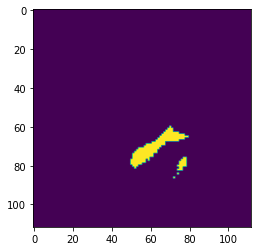

In [218]:
plt.imshow(res2[-2,:,:,0])

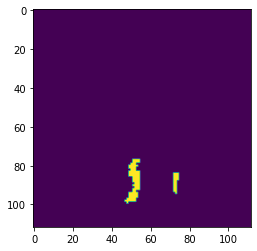

In [219]:
plt.imshow(y[-2])

In [220]:
A, B = res2[-2,:,:,0], y[-2]

In [224]:
np.sum(np.multiply(A, B))/np.sum(A+B>0)

0.05379746835443038

In [6]:
# make prediction for test
predictions = []
for d in test_data:
    prediction = np.array(np.zeros_like(d['video']), dtype=np.bool)
    height = prediction.shape[0]
    width = prediction.shape[1]
    prediction[int(height/2)-50:int(height/2+50), int(width/2)-50:int(width/2+50)] = True
    
    # DATA Strucure
    predictions.append({
        'name': d['name'],
        'prediction': prediction
        }
    )

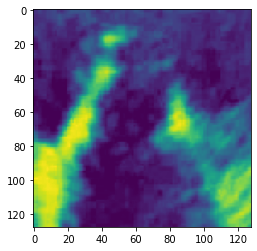

In [139]:
plt.imshow(X[4])

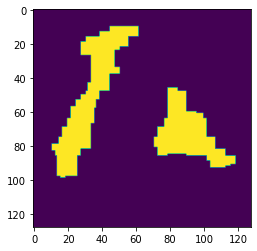

In [138]:
plt.imshow(y[4])

In [110]:
train_sample = train_data[41]

In [111]:
train_sample

{'name': 'DMKG04F0SB',
 'video': array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        ...,
 
        [[0, 1, 0, ..., 0, 0, 0],
         [2, 0, 0, ..., 0, 1, 0],
         [2, 0, 0, ..., 0, 1, 0],
         ...,
         [0, 1, 0, ..., 0, 0, 0],
         [0, 0, 1, ..., 0, 0, 1],
         [1, 0, 1, ..., 0, 1, 0]],
 
        [[2, 0, 1, ..., 1, 0, 0],
         [1, 1, 1, ..., 0, 0, 1],
 

In [14]:
video = train_sample['video']

In [24]:
label = train_sample['label']

In [16]:
video.shape

(112, 112, 196)

In [22]:
# minx, miny, maxx, maxy = 1, 1, 0, 0
# for train_example in train:
#     box = train_example['box']
#     video = train_example['video']
#     h = video.shape[0]
#     w = video.shape[1]
#     x, y = np.where(box)
#     minx, miny, maxx, maxy = min(x[0]/h, minx), min(y[0]/w, miny), max(x[-1]/h, maxx), max(y[-1]/w, maxy)
# print(minx, miny, maxx, maxy)

In [23]:
# minx, miny, maxx, maxy = 0.35, 0.45, 0.85, 0.7

In [113]:
box = train_sample['box']

In [121]:
np.where(box)

(array([49, 49, 49, ..., 76, 76, 76], dtype=int64),
 array([40, 41, 42, ..., 80, 81, 82], dtype=int64))

In [303]:
train[-1]

{'name': 'TFDB2R0ZSA',
 'video': array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        ...,
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
 

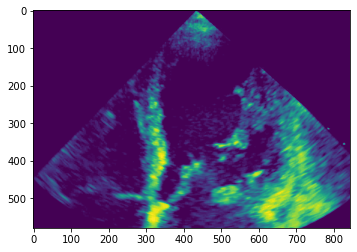

In [307]:
plt.imshow(train[-1]['video'][:,:,-1])

In [ ]:
pl

In [53]:
train_sample['frames']

[41, 65, 167]

In [46]:
np.where(label)

(array([57, 57, 57, 57, 58, 58, 58, 58, 59, 59, 59, 59, 60, 60, 60, 60, 60,
        60, 60, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 62, 62, 62, 62,
        62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62,
        62, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63,
        63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 64, 64,
        64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
        64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
        64, 64, 64, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65,
        65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65,
        65, 65, 65, 65, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66,
        66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66,
        66, 66, 66, 66, 66, 66, 66, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67,
        67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67,
        67, 

In [81]:
pred = predictions[5]['prediction']
pred

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [82]:
pred.shape

(583, 784, 159)

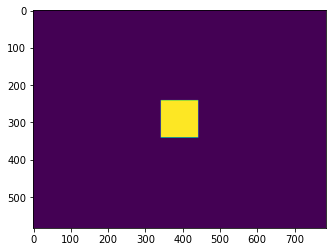

In [83]:
plt.imshow(pred[:,:,5])

In [71]:
test = test_data[3]
test

{'name': '7UXIXUBK2G',
 'video': array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        ...,
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
 

In [72]:
test['video'].shape

(587, 781, 104)

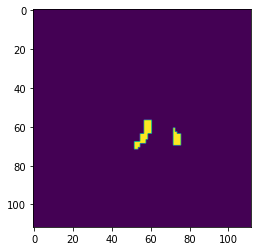

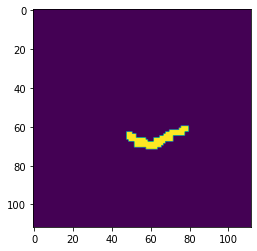

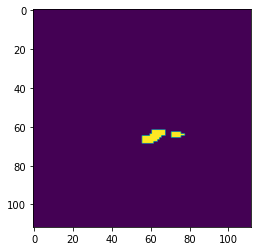

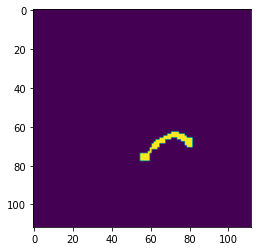

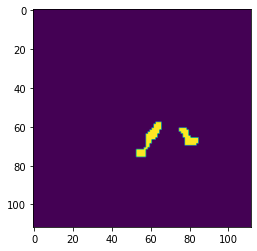

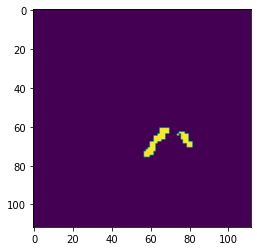

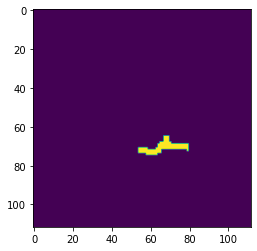

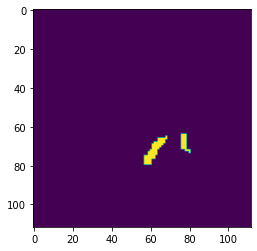

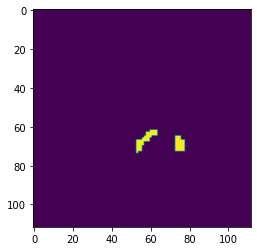

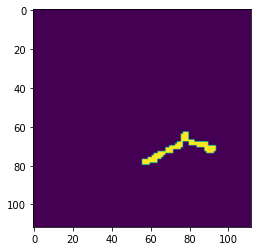

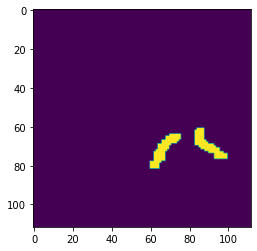

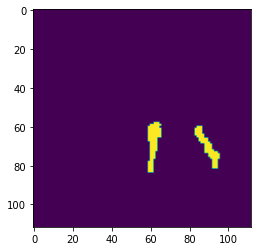

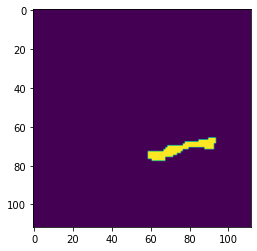

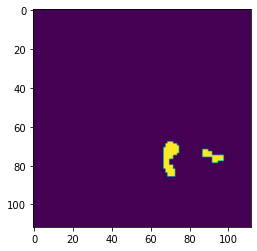

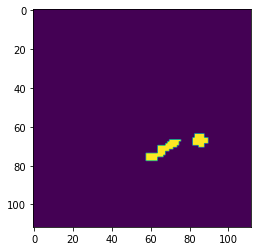

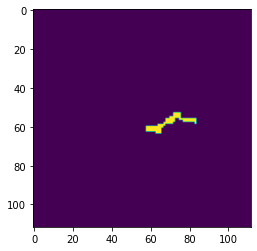

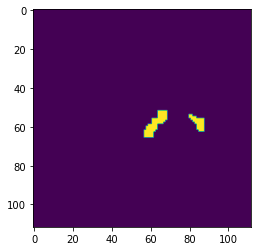

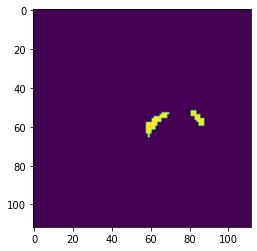

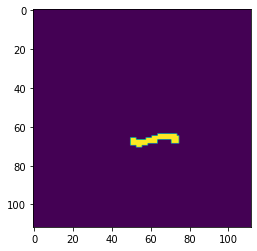

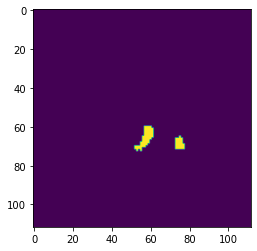

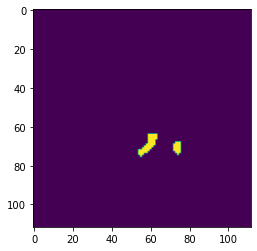

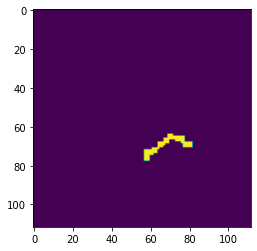

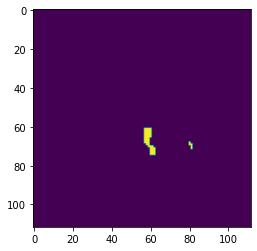

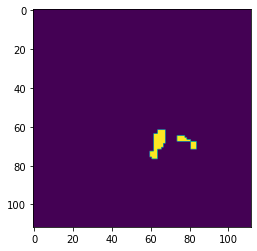

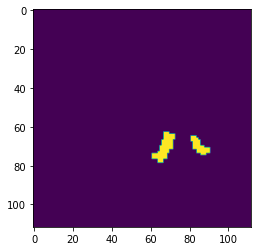

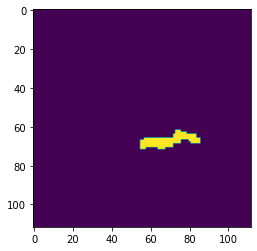

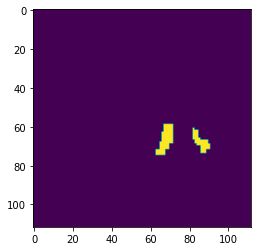

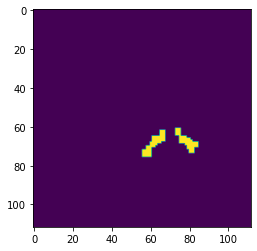

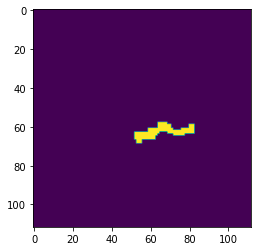

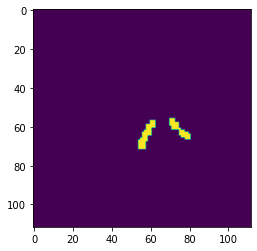

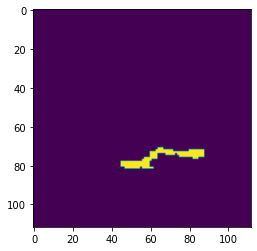

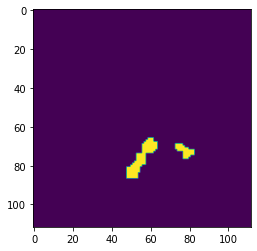

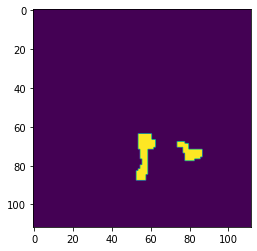

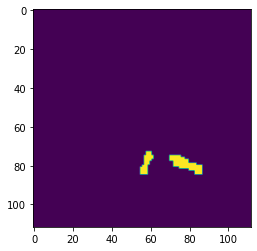

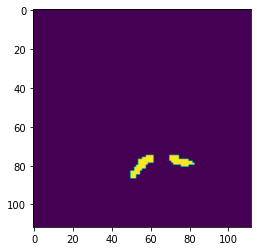

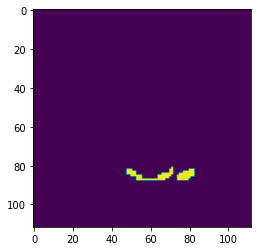

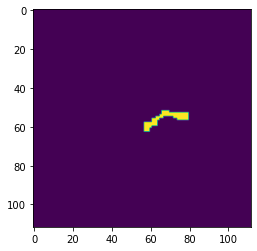

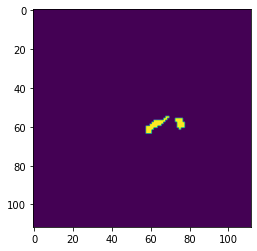

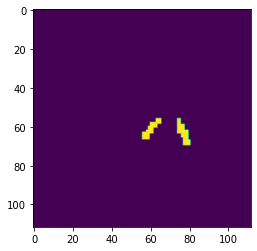

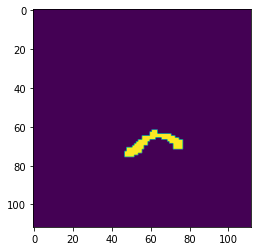

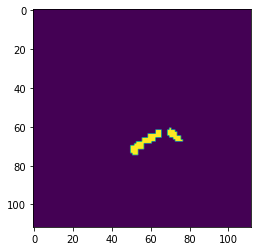

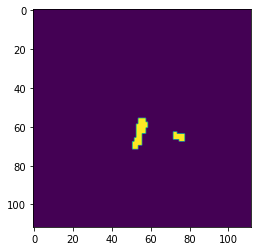

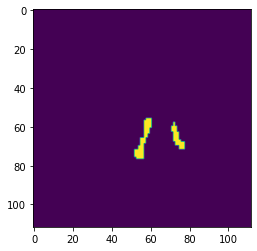

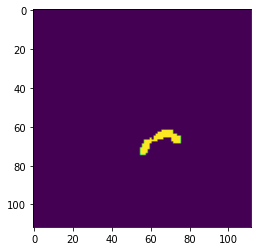

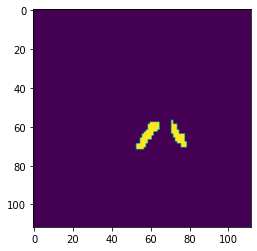

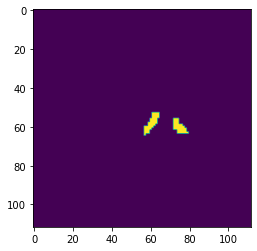

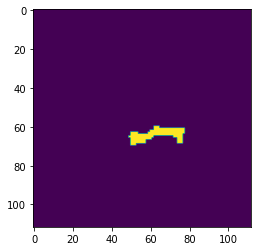

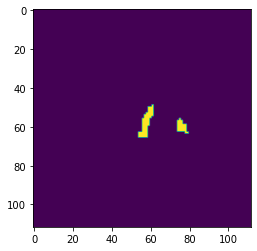

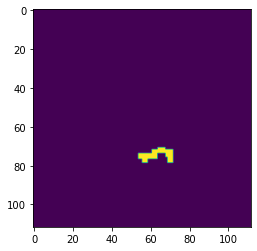

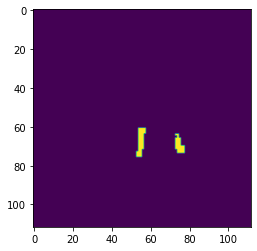

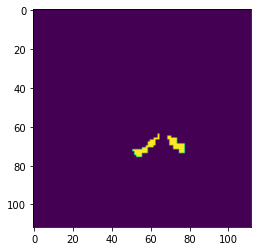

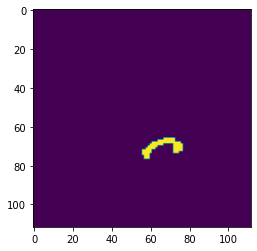

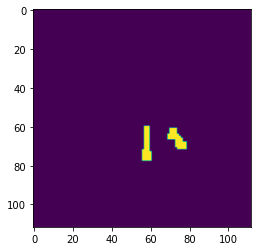

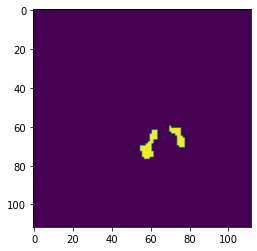

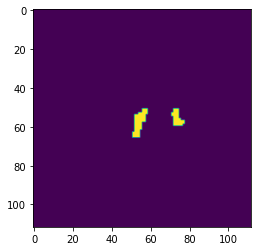

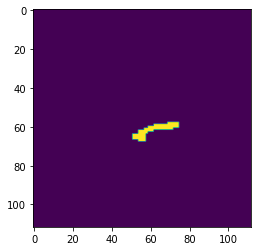

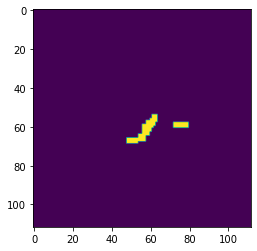

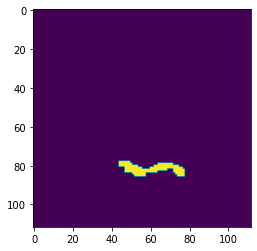

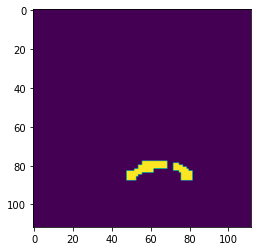

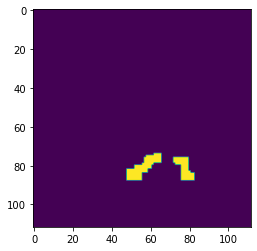

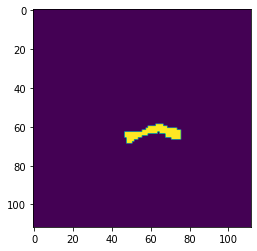

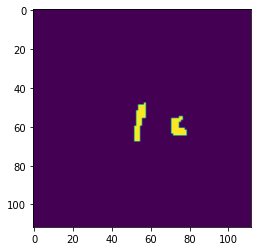

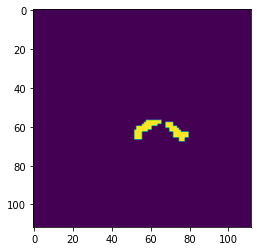

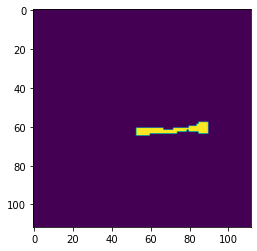

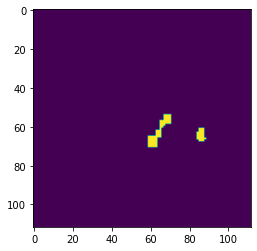

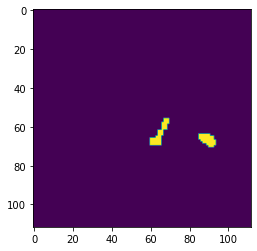

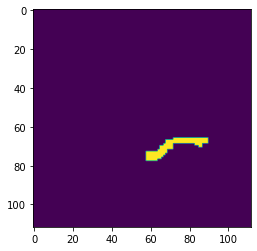

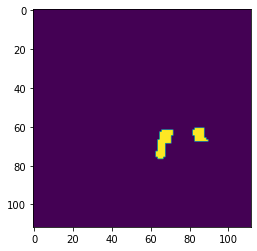

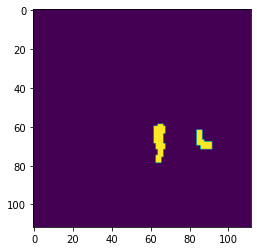

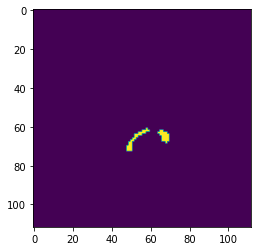

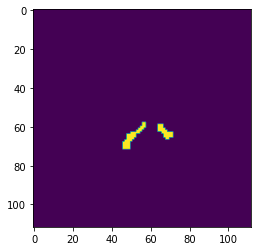

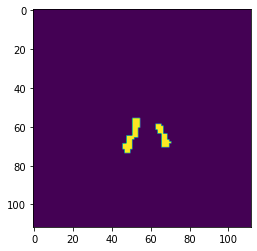

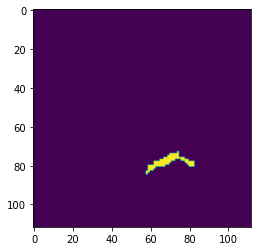

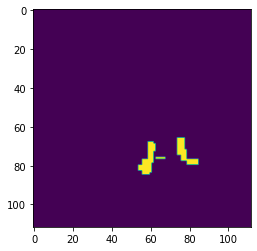

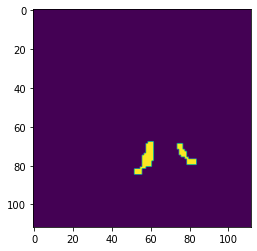

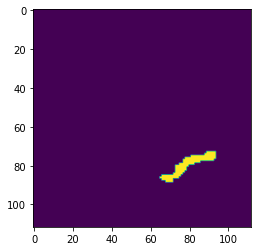

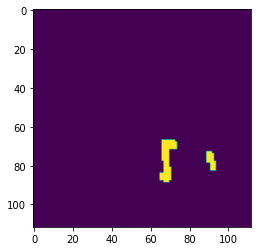

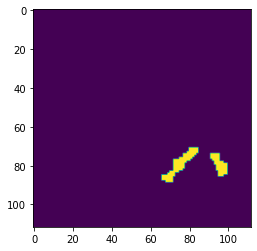

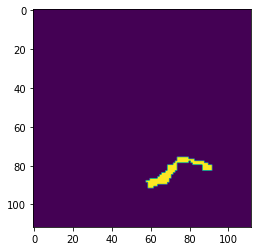

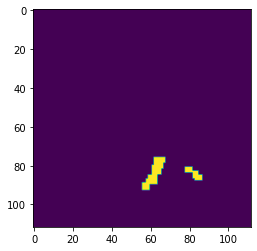

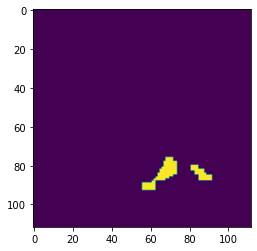

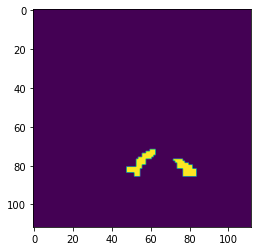

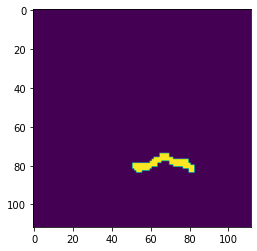

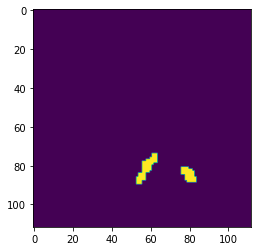

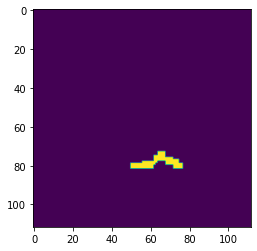

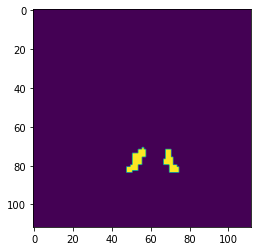

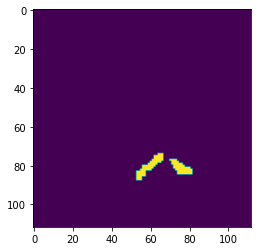

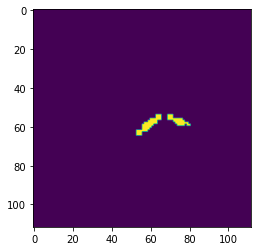

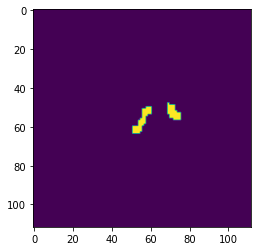

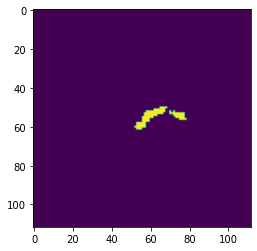

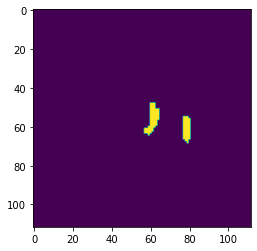

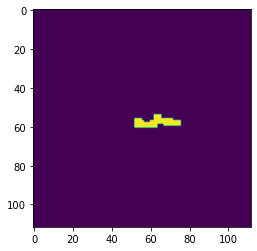

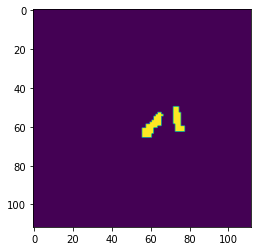

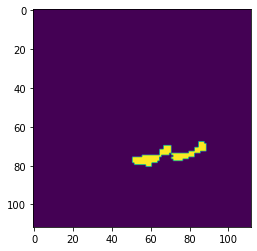

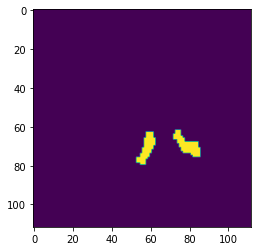

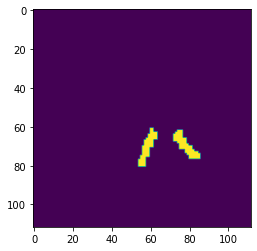

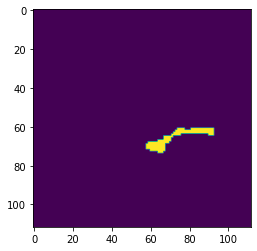

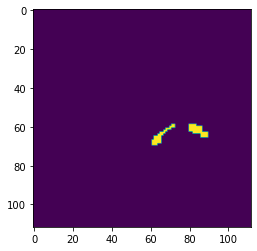

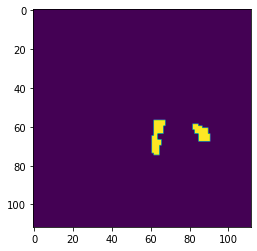

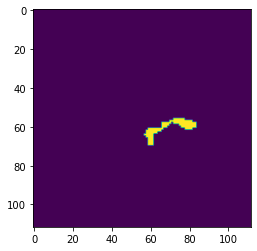

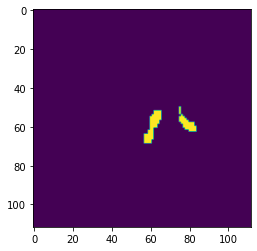

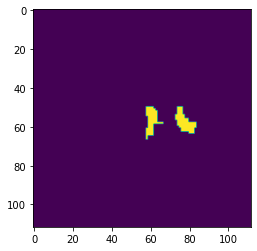

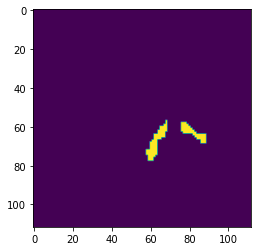

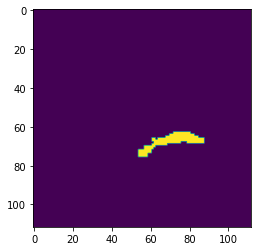

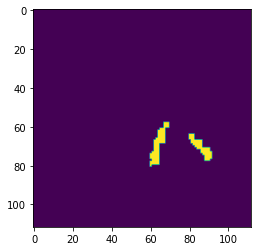

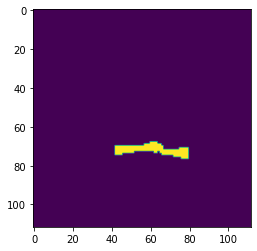

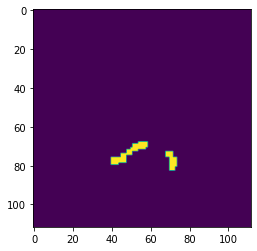

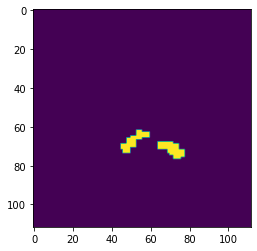

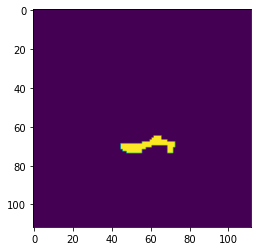

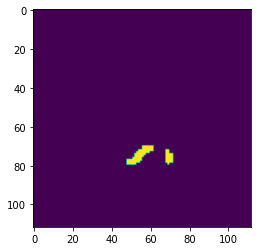

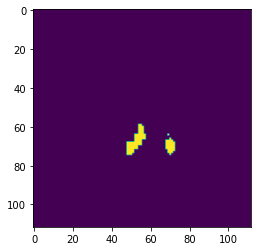

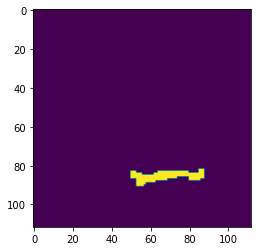

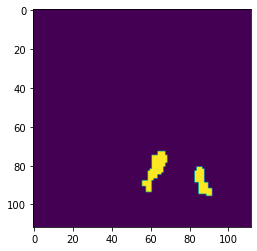

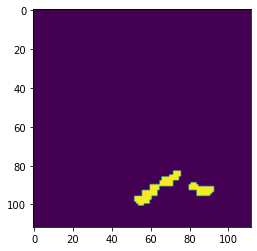

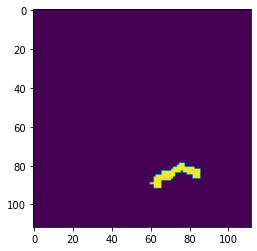

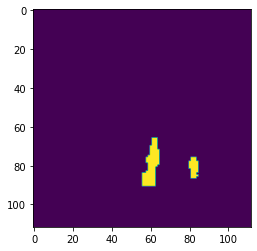

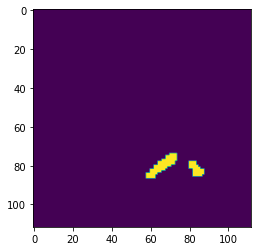

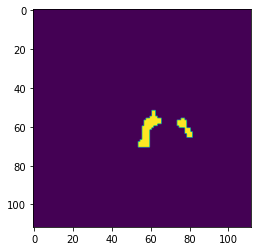

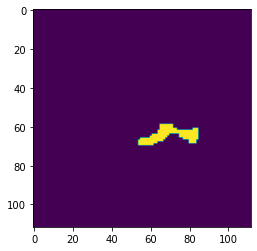

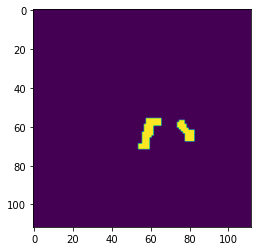

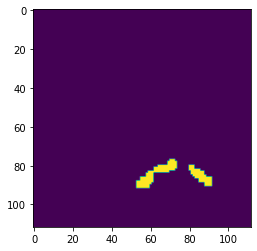

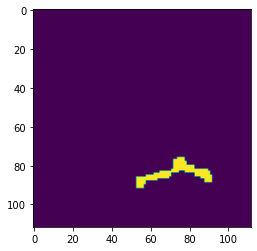

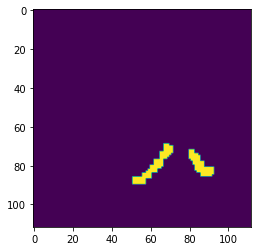

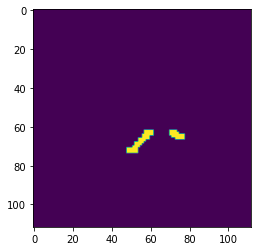

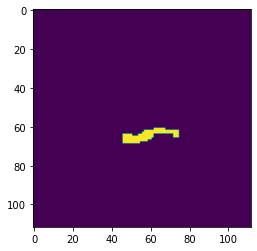

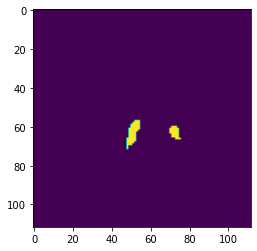

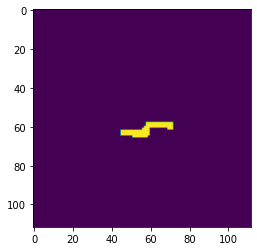

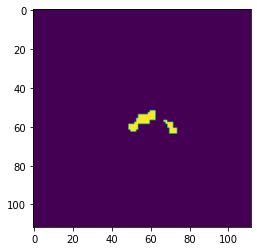

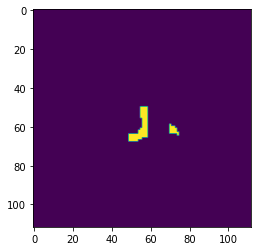

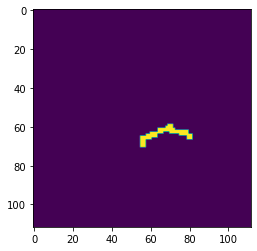

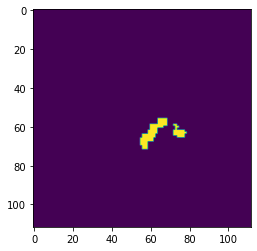

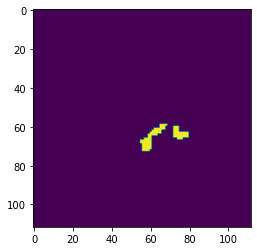

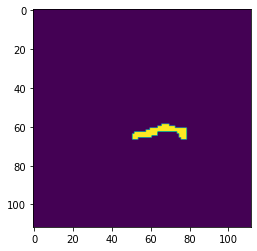

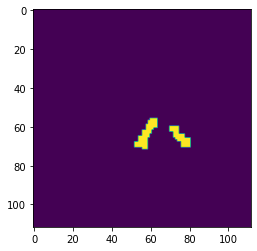

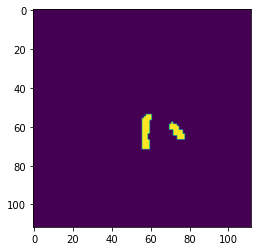

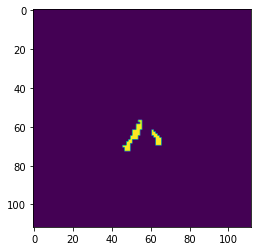

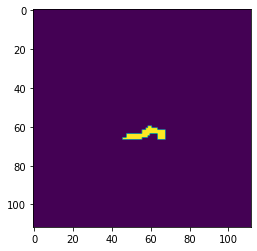

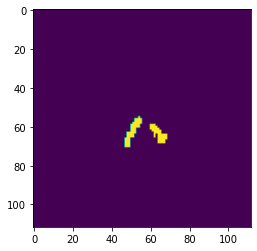

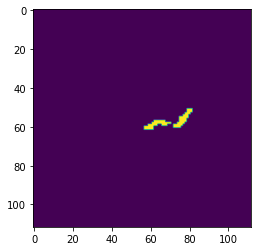

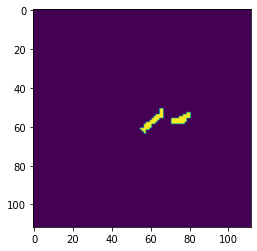

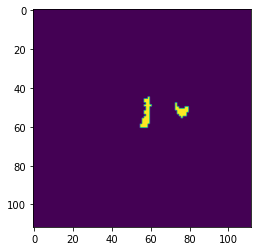

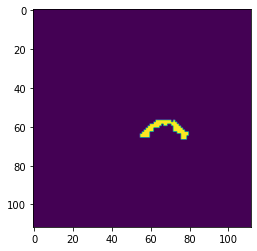

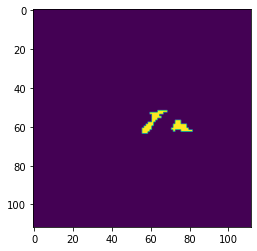

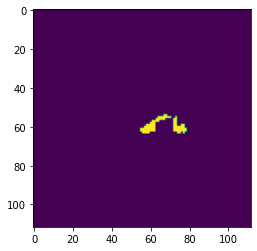

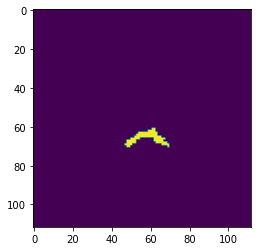

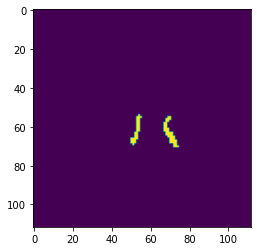

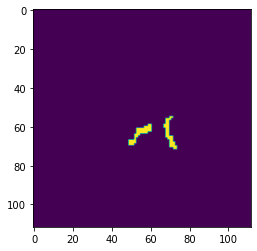

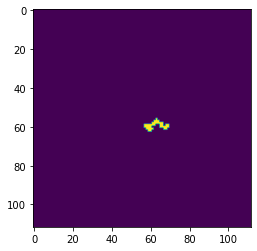

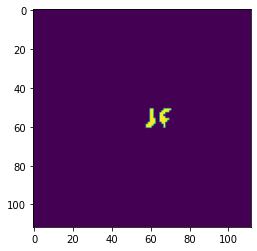

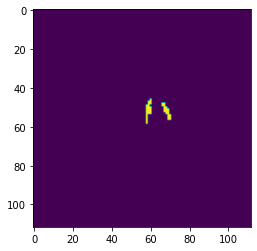

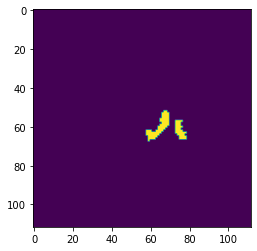

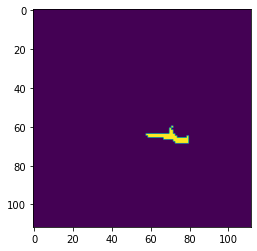

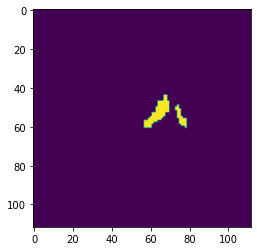

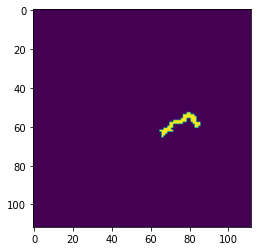

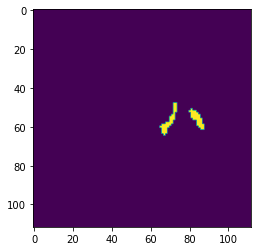

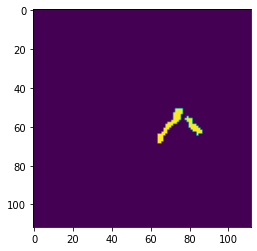

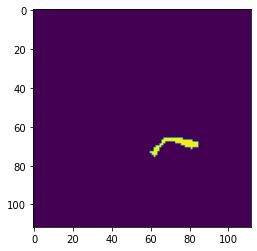

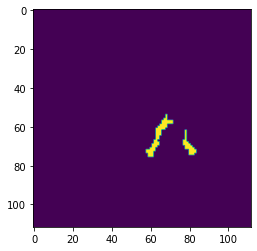

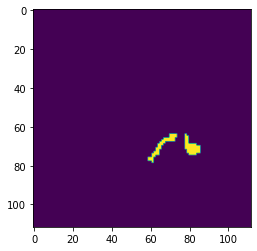

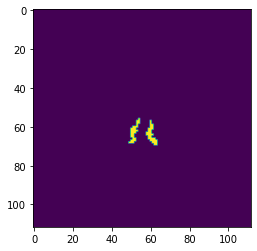

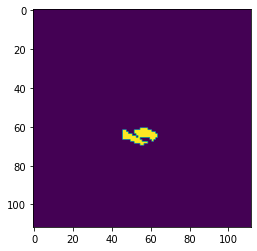

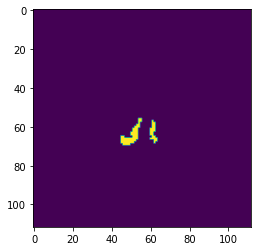

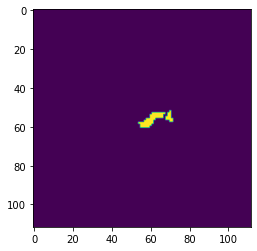

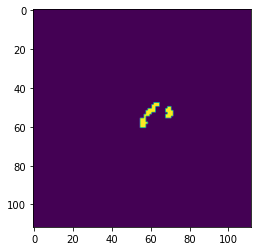

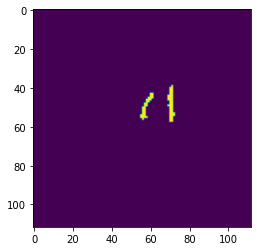

In [142]:
for i in range(len(y_train)):
    plt.imshow(y_train[i,:,:])
    plt.show()

In [455]:
%matplotlib inline
import matplotlib
import ipywidgets
from PIL import Image
matplotlib.rcParams.update({'figure.max_open_warning': 0}) #avoids a warning about how many figures to keep in memory


In [159]:
def display_simulation():
    global FIGS
    slider = ipywidgets.IntSlider(value=0,
                                  min=0,
                                  max=len(FIGS)-2)

    def figshow(i):
        return display(FIGS[i])

    ipywidgets.interact(figshow,i=slider);

In [160]:
FIGS = [Image.fromarray(y_train[i,:,:]) for i in range(len(y_train))]

In [161]:
display_simulation()

interactive(children=(IntSlider(value=0, description='i', max=163), Output()), _dom_classes=('widget-interact'…